# Create fask_mask_detection using transfer learning...!!!!

In [1]:
import tensorflow as tf
import cv2

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os

**Basically start with loading of image or load the dataset... initial stage..!!!**

In [3]:
img_array = cv2.imread('dataset/Face_Mask/00000_Mask.jpg')

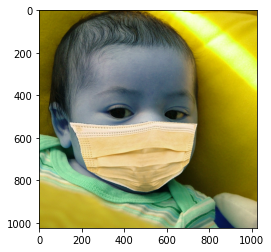

In [4]:
plt.imshow(img_array) ## BRG colour image...

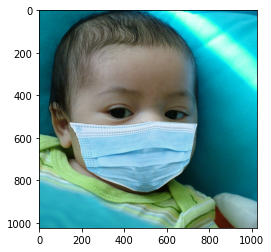

In [5]:
## convert BGR image into RGB image
plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))

In [7]:
img_array.shape

(1024, 1024, 3)

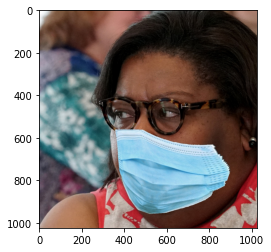

In [11]:
Datadirectory = 'dataset/'  # training dataset...
Classes = ['Face_Mask','No_Mask']
for category in Classes:
    path = os.path.join(Datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

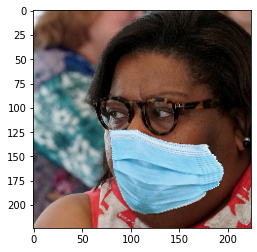

In [14]:
img_size = 224 # imagenet bydefault pixel size..
new_array = cv2.resize(img_array,(img_size,img_size))
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
new_array.shape

(224, 224, 3)

## Read all images and convert into array.. {imagetag,image}[data,labels]

In [16]:
training_Data = [] # empty list store the data and labels of datasets in the form of array...!!!

def create_training_Data():
    
    for category in Classes:
        path = os.path.join(Datadirectory,category)
        class_num = Classes.index(category) # Here we create labels for each image..
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))   # 
                new_array = cv2.resize(img_array,(img_size,img_size))
                training_Data.append([new_array,class_num])
            except Exception as e:
                pass

In [17]:
# Function call to read all the image inside the folder and create array with the labels..!!!
create_training_Data()

In [19]:
print(len(training_Data))

1950


In [20]:
## To avoid overfitting to data into training Neural Network..!!!
import random

random.shuffle(training_Data)

In [27]:
X = []
y = []

for features,label in training_Data:
    X.append(features)
    y.append(label)

# convert all images into array..    
X = np.array(X).reshape(-1,img_size,img_size,3)  # add 4 dimension in image all known for depth of image according to model architecture..
y = np.array(y)

In [35]:
X.shape

(1950, 224, 224, 3)

In [36]:
y.shape

(1950,)

In [30]:
## Normalize the X imagedata...!!!

X = X/255.0;

### Best practice to make pickle file so we not reagain run the above code next_tym if required..!!!

In [31]:
import pickle

pickle_out = open("X.pickle",'wb')
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle",'wb')
pickle.dump(y,pickle_out)
pickle_out.close()

**Again load the pickle file for further manipulation... or not load the similar data**

In [3]:
import pickle
pickle_in = open('X.pickle','rb')
X = pickle.load(pickle_in)

pickle_in = open('y.pickle','rb')
y = pickle.load(pickle_in)

# Deep learning model for training- transfer learning..

In [4]:
# tensorflow 2.0 and keras both are same.. only diffrence is tensorflow use keras api and keras is self library..!!
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# Load the transfer learning pretrain model....!!!
# various transfer learning model are already comes with tensorflow 2.0 library/package/module..
# first time run by using parameter weights= imagenet to download the weights..
model = tf.keras.applications.mobilenet.MobileNet(weights='imagenet')

In [6]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

**As we use transfer learning modify the last three layers for over usage and remaining were the same..!!**

# Transfer learning--

In [7]:
# cut the input layer first then go for further...
base_input = model.layers[0].input

In [8]:
# Cut the last few layers still before the flatten layers then add over layers over their..!!!
## cutting and adding the layers is very useful to avoid train whole weights again & again..!!!
base_output = model.layers[-4].output

In [9]:
# add over know layers..!!!
Flat_layer = layers.Flatten()(base_output) # it is written in latest api calling of tf 2.0 version..!!!
final_output = layers.Dense(1)(Flat_layer)

final_ouput = layers.Activation('sigmoid')(final_output)

In [10]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [11]:
# check the new model summary --- how many parameters it actually consist..
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

## Now train our model for binary classification(face_mask and without_face_mask)

In [12]:
## create the compile function to fit all the optimizer values...
# use binary_crossentropy bcoz it quite efficent with sigmoid function..!!

new_model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

**Now train the model with optimal epochs..**

In [13]:
new_model.fit(X, y, epochs=2, validation_split=0.1)

Epoch 1/2
55/55 [==============================] - 267s 5s/step - loss: 0.2567 - accuracy: 0.9783 - val_loss: 0.2373 - val_accuracy: 0.9846
Epoch 2/2
55/55 [==============================] - 257s 5s/step - loss: 0.0087 - accuracy: 0.9994 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [14]:
## jst save this model..
new_model.save('my_model.h5')

### Here we start the main detection process of face..!!

In [15]:
## first load the best trained model with maximum accuracy..
new_model = tf.keras.models.load_model('my_model.h5')

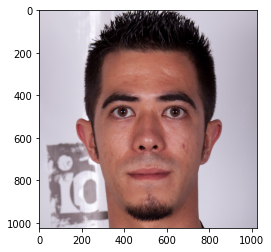

In [17]:
## Check the trained network for prediction... with some predefine face detection models in cv2..
frame = cv2.imread('sad_women.jpg')
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [18]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [19]:
## for cv2 jst convert image into gray..
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

In [23]:
## detect the face using opencv and draw rectangle on it..
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame,(x,y),( x+w ,y+h ),(255,0,0),2)
    facess = faceCascade.detectMultiScale(roi_gray)
    
    if len(facess) == 0:
        print('Face Not detected')
    else:
        for (ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey: ey+eh , ex: ex+ew]

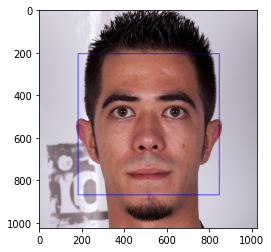

In [24]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

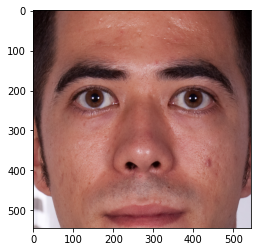

In [25]:
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))

In [26]:
## lets predict the above img with over model..!!!
final_image = cv2.resize(face_roi,(224,224))
final_image = np.expand_dims(final_image,axis=0) ## model works with 4 dims..
final_image = final_image/255.0

In [27]:
predictions = new_model.predict(final_image)

In [28]:
predictions

array([[13.11658]], dtype=float32)

### above result we see that if person not wear a mask model give positive output, use this inform in live detection..

# Realtime -demo..

## face_mask detection..

In [37]:
#import winsound
#frequency = 2500
#duration = 1000
 

import cv2 ### pip install opencv-python

path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

## set the rectangle background to window...
rectangle_bgr = (255,255,255)
## make a black image..
img = np.zeros((500,500))
## set some text
text = "Some text in a box!!"
## get the width and height of the text box..
(text_width, text_height) = cv2.getTextSize(text, font,fontScale = font_scale, thickness=1)[0]

#set the text start position..
text_offset_x = 10
text_offset_y = img.shape[0]-25

## make the coords of the box with a small padding of two pixels..
box_coords = ((text_offset_x,text_offset_y),(text_offset_x + text_width + 2,text_offset_y - text_height -2))
cv2.rectangle(img,box_coords[0],box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x,text_offset_y), font, fontScale = font_scale, color =(0,0,0), thickness = 1)

## condition if the camera is not as default point..
cap = cv2.VideoCapture(1)
## check fi the webcam is opened correctly..
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open the webcam...")

## using above variable finally detect the image in realtime...
while True:
    ret,frame = cap.read()
    ## caught the face using facecascade, if we want eye caught use haarcascade_eye..
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    ## detect the face using opencv and draw rectangle on it..
    faces = faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame,(x,y),( x+w ,y+h ),(255,0,0),2)
        facess = faceCascade.detectMultiScale(roi_gray)
    
        if len(facess) == 0:
            print('Face Not detected')
        else:
            for (ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey: ey+eh , ex: ex+ew]
    # adjust img according to model..
    final_image = cv2.resize(face_roi,(224,224))
    final_image = np.expand_dims(final_image,axis=0) ## model works with 4 dims..
    final_image = final_image/255.0
    font = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX
    predictions = new_model.predict(final_image)
    
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    
    if (predictions>0):
        status = 'No Mask'
        
        x1,y1,w1,h1 = 0,0,175,75
        # draw black background rectangle..
        cv2.rectangle(frame, (x1,y1), (x1+w1 , y1+h1), (0,0,0), -1)
        # add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1+ int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)
        
        cv2.putText(frame, status, (100,50), font, 3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w,y+h),(0,0,255))
        #winsound.Beep(frequency,duration)
    else:
        status = 'Face Mask'
        
        x1,y1,w1,h1 = 0,0,175,75
        # draw black background rectangle..
        cv2.rectangle(frame, (x1,y1), (x1+w1 , y1+h1), (0,0,0), -1)
        # add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1+ int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),2)
        
        cv2.putText(frame, status, (100,50), font, 3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w,y+h),(0,255,0))
    
    ## insert hedline on videoframe..
    cv2.imshow('Realtime face-mask detection',frame)
    
    ## press q to quite the video frame if your wants it..
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
        

ModuleNotFoundError: No module named 'winsound'